In [1]:
import numpy as np
import sys
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import interferometer as itf
sys.path.append('../') # Add parent directory to the system path

In [2]:
# This import requires previous directory to be appended to sys.path
from direct_decomposition import direct_decomposition

In [10]:
# Unitaries for the R = 1/2, R = 1/3 and the flipped R = 1/3 beamsplitters
U_onehalf = 1/np.sqrt(2) * np.matrix([[1,1],[1,-1]])

a = np.sqrt(1/3) # a and b are placeholders
b = np.sqrt(2/3)
U_onethird = np.matrix([[a,b],[b,-a]])
U_flipped_onethird = np.matrix([[-a,b],[b,a]]) # TODO: This could be wrong?

In [16]:
# Get theta and phi values for beamsplitters according to itf decomposition
BS_onehalf = itf.square_decomposition(U_onehalf)
BS_onethird = itf.square_decomposition(U_onethird)
BS_flipped_onethird = itf.square_decomposition(U_flipped_onethird)

print("50-50 beamsplitter")
print(BS_onehalf.BS_list)
print(BS_onehalf.output_phases)
print("\n")

print("1/3 beamsplitter")
print(BS_onethird.BS_list)
print(BS_onethird.output_phases)
print("\n")

print("Flipped 1/3 beamsplitter")
print(BS_flipped_onethird.BS_list)
print(BS_flipped_onethird.output_phases)

50-50 beamsplitter
[
 Beam splitter between modes 1 and 2: 
 Theta angle: 0.79 
 Phase: 3.14]
[-3.141592653589793, -3.141592653589793]


1/3 beamsplitter
[
 Beam splitter between modes 1 and 2: 
 Theta angle: 0.96 
 Phase: 3.14]
[-3.141592653589793, -3.141592653589793]


Flipped 1/3 beamsplitter
[
 Beam splitter between modes 1 and 2: 
 Theta angle: 0.96 
 Phase: 0.00]
[3.141592653589793, 0.0]


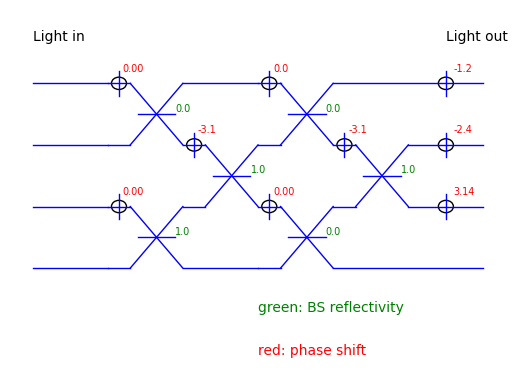

In [21]:
# What does the square decomp of a cnot look like?
CNOT = np.matrix([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
I = itf.square_decomposition(CNOT)
I.draw()

In [22]:
for BS in I.BS_list:
    print(BS)


 Beam splitter between modes 1 and 2: 
 Theta angle: 1.57 
 Phase: 0.00

 Beam splitter between modes 3 and 4: 
 Theta angle: 0.00 
 Phase: 0.00

 Beam splitter between modes 2 and 3: 
 Theta angle: 0.00 
 Phase: -3.14

 Beam splitter between modes 1 and 2: 
 Theta angle: 1.57 
 Phase: 0.00

 Beam splitter between modes 3 and 4: 
 Theta angle: 1.57 
 Phase: 0.00

 Beam splitter between modes 2 and 3: 
 Theta angle: 0.00 
 Phase: -3.14


In [8]:
# TODO: Figure out how this is being calculated.
BS_onehalf.calculate_transformation()

array([[ 0.70710678+0.00000000e+00j,  0.70710678+8.65956056e-17j],
       [ 0.70710678+0.00000000e+00j, -0.70710678-8.65956056e-17j]])

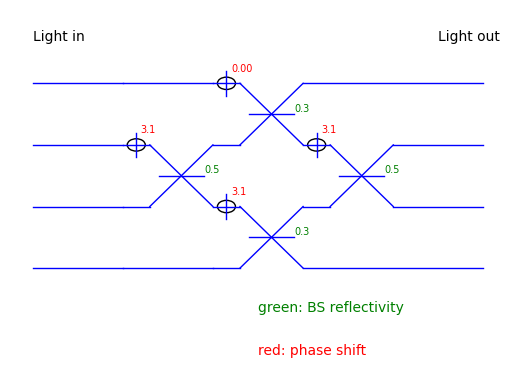

In [6]:
# Make interferometer
# Usage: Beamsplitter(mode1, mode2, theta, phi)
theta3 = 0.9553166181245093

bs1 = itf.Beamsplitter(2, 3, np.pi/4, np.pi)
bs2 = itf.Beamsplitter(1, 2, theta3, 0)
bs3 = itf.Beamsplitter(3, 4, theta3, np.pi)
bs4 = itf.Beamsplitter(2, 3, np.pi/4, np.pi)

I = itf.Interferometer()

# There are global phases that I'm missing also?
for bs in [bs1, bs2, bs3, bs4]:
    I.add_BS(bs)

I.draw()


In [7]:
# U = I.calculate_transformation()
# test = itf.square_decomposition(U)
# test.draw()
# There are some slight variations... It should be fine?

In [8]:
U = I.calculate_transformation()
CNOT_circuit = direct_decomposition(U, 2)
print(CNOT_circuit.num_qubits)
print(CNOT_circuit.depth())

8
580


In [9]:
# Initial states for CNOT simulation
# TODO: Don't bother with this approach, just use initialize
c1_t0 = QuantumCircuit(CNOT_circuit.num_qubits) # One photon in mode c1, one photon in mode t0
# c1_t0.x(0) # 00, 00, 00, 01
c1_t0.x(2) # 00, 00, 01, 00

c1_t1 = QuantumCircuit(CNOT_circuit.num_qubits) # One photon in mode c1, one photon in mode t1
# c1_t1.x(0) # 00, 00, 00, 01
c1_t1.x(4) # 00, 01, 00, 00

In [10]:
circ0 = c1_t0.compose(CNOT_circuit, qubits=list(range(c1_t0.num_qubits)), inplace=False)
circ0.measure_all()

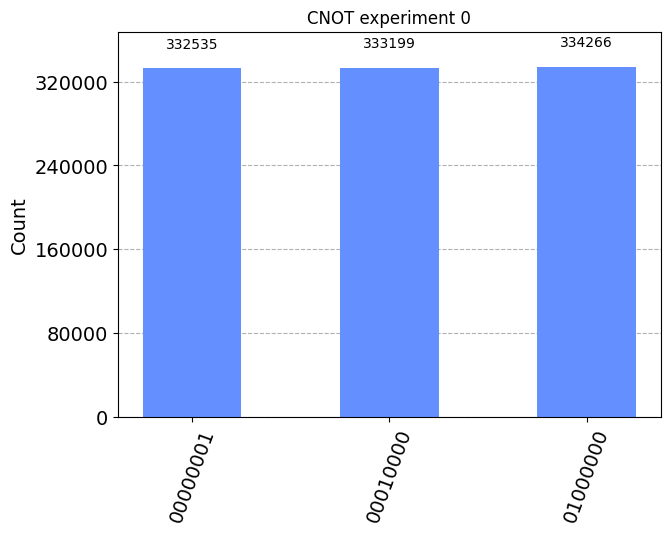

In [11]:
num_shots = 1e6
simulator = AerSimulator()
circ0 = transpile(circ0, simulator)
result = simulator.run(circ0, shots=num_shots).result()
counts = result.get_counts(circ0)
plot_histogram(counts, title='CNOT experiment 0')

In [12]:
circ1 = c1_t1.compose(CNOT_circuit, qubits=list(range(c1_t1.num_qubits)), inplace=False)
circ1.measure_all()

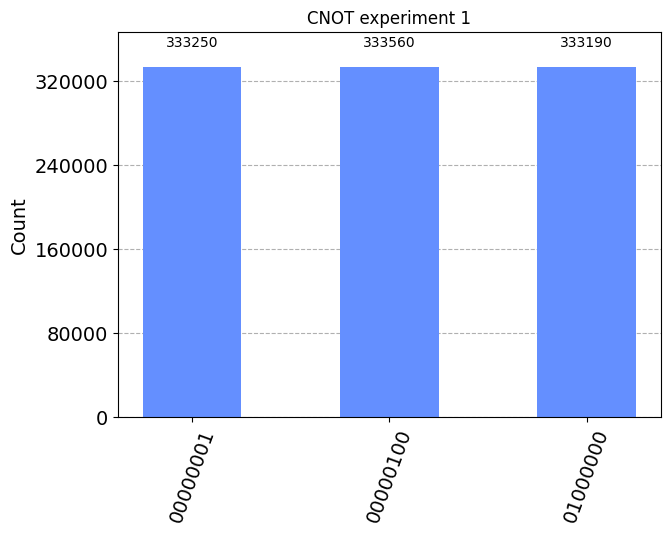

In [13]:
num_shots = 1e6
simulator = AerSimulator()
circ1 = transpile(circ1, simulator)
result = simulator.run(circ1, shots=num_shots).result()
counts = result.get_counts(circ1)
plot_histogram(counts, title='CNOT experiment 1')

Why am I constructing a CNOT from beamsplitter elements instead of just running my code? Not sure if that's sensible...

In [ ]:
# What does the square decomp of a cnot look like?
CNOT = np.matrix([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
I = itf.square_decomposition(CNOT)
I.draw()

In [23]:
def run_circuit_simulation(U, initial_state, num_shots, num_photons):
    num_modes = int(np.shape(U)[0])
    qubits_per_mode = int(np.ceil(np.log2(num_photons + 1)))
    num_qubits = qubits_per_mode * num_modes
    circuit = QuantumCircuit(num_qubits)
    
    print(f"Initial state: {initial_state}")
    circuit.initialize(initial_state)
    # circuit.initialize("000101")
    interferom = direct_decomposition(R, num_photons)
    circuit.compose(interferom, qubits=list(range(num_qubits)), inplace=True)
    circuit.measure_all()

    simulator = AerSimulator()
    circuit = transpile(circuit, simulator)
    result = simulator.run(circuit, shots=num_shots).result()
    counts = result.get_counts(circuit)

    # Convert counts to probabilities
    for key in counts.keys():
        counts[key] = counts[key] / num_shots
    return counts

In [ ]:

run_circuit_simulation(CNOT, "00000000")